## LINEAR AUTOENCODER

In [27]:
# Parts of this code are inspired by 
# GeeksforGeeks (2022): Implementing an Autoencoder in PyTorch. Available online at https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/, updated on 7/7/2022, checked on 7/16/2024.

In [28]:
import torch
import matplotlib.pyplot as plt
from dataset.cycling_dataset import TorchCyclingDataset
from notebooks.autoencoder.linear_ae import LINEAR_AE

from tqdm import tqdm
from statistics import mean
import numpy as np

In [29]:
BATCH_SIZE = 8

In [30]:
def plot(losses):
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
     
    # Plotting
    plt.plot(losses)

In [31]:
# Load preprocessed datasets
backwheel_test = TorchCyclingDataset(file_path_acc="../../data/preprocessed/backwheel_acc_test.h5",
                             file_path_gyro="../../data/preprocessed/backwheel_gyro_test.h5")
backwheel_train = TorchCyclingDataset(file_path_acc="../../data/preprocessed/backwheel_acc_train.h5",
                              file_path_gyro="../../data/preprocessed/backwheel_gyro_train.h5")

handlebar_test = TorchCyclingDataset(file_path_acc="../../data/preprocessed/handlebar_acc_test.h5",
                             file_path_gyro="../../data/preprocessed/handlebar_gyro_test.h5")
handlebar_train = TorchCyclingDataset(file_path_acc="../../data/preprocessed/handlebar_acc_train.h5",
                              file_path_gyro="../../data/preprocessed/handlebar_gyro_train.h5")

In [32]:
# DataLoader is used to load the dataset 
# for training
backwheel_test_loader = torch.utils.data.DataLoader(dataset = backwheel_test,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)
backwheel_train_loader = torch.utils.data.DataLoader(dataset = backwheel_train,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)

handlebar_test_loader = torch.utils.data.DataLoader(dataset = handlebar_test,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)
handlebar_train_loader = torch.utils.data.DataLoader(dataset = handlebar_train,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)

In [33]:
handlebar_train[0].shape

torch.Size([100, 6])

In [34]:
# from https://github.com/shobrook/sequitur/blob/master/sequitur/quick_train.py, 2024-07-20

def train_model(model, train_set, verbose, lr, epochs):
    # model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    mean_losses = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()

        losses = []
        for x in train_set:
            optimizer.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimizer.step()
    
            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses

In [35]:
# Autoencoder model
model = LINEAR_AE(input_dim=100*6,
                  encoding_dim=100,
                  h_dims=[512,256,128],
                  h_activ=torch.nn.ReLU(),
                  out_activ=torch.nn.Sigmoid(),
                  )

In [36]:
model.encoder

Encoder(
  (nn): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=100, bias=True)
    (8): Sigmoid()
  )
)

In [37]:
model.decoder

Decoder(
  (nn): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=600, bias=True)
    (7): Unflatten(dim=1, unflattened_size=(100, 6))
  )
)

In [38]:
mean_losses = train_model(model, handlebar_train_loader, verbose=False, lr=1e-3, epochs=30)

100%|██████████| 30/30 [03:10<00:00,  6.33s/it]


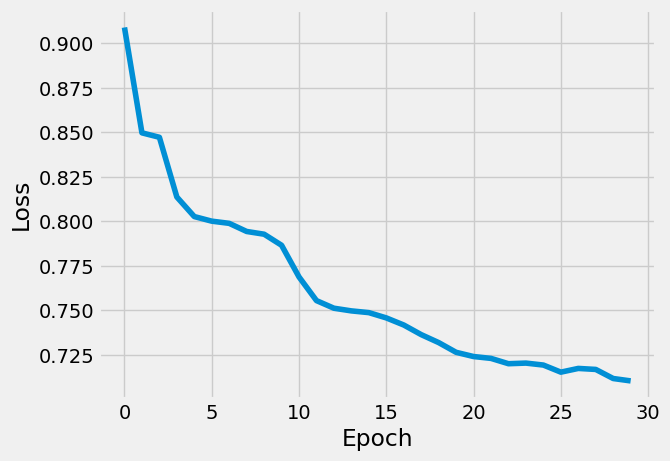

In [39]:
plot(mean_losses)

In [40]:
torch.save(model.state_dict(), './saved_models/linear_encoder.pt')